In [436]:
import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import Pool, CatBoostClassifier

import isodate
import datetime

import re

from gensim.models import FastText
import gensim

In [276]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [277]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
#           "https://www.googleapis.com/auth/youtubepartner-channel-audit",
#           "https://www.googleapis.com/auth/youtubepartner"]

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "my_client_desktop.json"
channel_id = 'UCQIRSud94PUpBjMIjM_wgiA'
# channel_id = 'UC0MpTTqWtX6xUFR8Ee4Vd6A' # Айсена Андреева (Канал Алексея)
# channel_id = 'UC9wpw9wWC-8kCs4ho7Uiptw' # Id Айсена Антонова

In [279]:
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=543654904839-lltmk49hvj2bb11eofgrhemrg2djtv89.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=Xk56LDci2RvdflC2nfFFkiSQ0UpA6j&prompt=consent&access_type=offline
Enter the authorization code: 4/1AfJohXnRFFZpEMHWRUjnR2Trbn3FdiNLdg8Inx2sXvVGwOJarT-QlO67rQQ


## Функция для получения статистики о канале

In [280]:
def get_channel_stats(youtube, channel_id):
    
    request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id)
    response = request.execute()
    
    data = dict(Channel_name = response['items'][0]['snippet']['title'],
                Subscribers = response['items'][0]['statistics']['subscriberCount'],
                Description = response['items'][0]['snippet']['description'],
                Views = response['items'][0]['statistics']['viewCount'],
                Total_videos = response['items'][0]['statistics']['videoCount'])
    
    return data

In [281]:
channel_statistics = get_channel_stats(youtube, channel_id)
channel_data = pd.DataFrame(channel_statistics, index=[0])
# channel_data

## Функция для получения статистики о понравившихся видео (Алгоритмы YouTube)

In [282]:
def get_my_liked_videos_stats(youtube):
    all_data = []
    nextPageToken = None
    for i in range(1, 40):  # 40 Потому что больше 2000 данных будет избыточно.
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,player",
            myRating="like",
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(PublishedAt = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['channelId'],
                        Title = response['items'][i]['snippet']['title'],
                        Tags = response['items'][i]['snippet'].get('tags'),
                        Kind = response['items'][i]['kind'],
                        Description = response['items'][i]['snippet']['description'],
                        ChannelTitle = response['items'][i]['snippet']['channelTitle'],
                        Id_video_category = response['items'][i]['snippet']['categoryId'],
                        liveBroadcastContent = response['items'][i]['snippet']['liveBroadcastContent'],
                        Duration = response['items'][i]['contentDetails']['duration'],
                        ViewCount = response['items'][i]['statistics'].get('viewCount'),
                        LikeCount = response['items'][i]['statistics'].get('likeCount'),
                        )
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [283]:
my_liked_videos_stats = get_my_liked_videos_stats(youtube)
my_liked_videos_data = pd.DataFrame(my_liked_videos_stats)
# my_liked_videos_data

## Функция для получения RU категорий на YouTube

In [284]:
def get_video_categories(youtube):
    all_data = []
    request = youtube.videoCategories().list(
        part="snippet",
        hl="RU",
        regionCode="RU"
    )
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Id_video_category = response['items'][i]['id'],
                    Category = response['items'][i]['snippet']['title'],
                    Assignable = response['items'][i]['snippet']['assignable'], # Имеет ли возможность иметь несколько категорий
                    )
        all_data.append(data)
    return all_data

In [285]:
video_categories = get_video_categories(youtube)
video_categories_data = pd.DataFrame(video_categories)
# video_categories_data

## Функция для получения статистики о подписках

In [286]:
def get_subscriptions_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.subscriptions().list(
            part="snippet,contentDetails,subscriberSnippet,id",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Channel_name = response['items'][i]['snippet']['title'],
                        Description = response['items'][i]['snippet']['description'],
                        Subscription_time = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['resourceId']['channelId'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [287]:
subscriptions_stats = get_subscriptions_stats(youtube, channel_id)
subscriptions_stats_data = pd.DataFrame(subscriptions_stats)
# subscriptions_stats_data

## Функция для получения статистики об активностях

In [288]:
def get_activities_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.activities().list(
            part="snippet,contentDetails",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Date = response['items'][i]['snippet']['publishedAt'],
                    Channel_name = response['items'][i]['snippet']['channelTitle'],
                    type = response['items'][i]['snippet']['type'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [289]:
activities_statistics = get_activities_stats(youtube, channel_id)
activities_data = pd.DataFrame(activities_statistics)
# activities_data

## Аналитика данных

Читаем файл video_categories_weights с весами.

In [290]:
video_categories_weights = pd.read_excel('video_categories.xlsx')
# video_categories_weights

Приведение типов с object на int для того, чтобы можно было посмотреть данные и обучить модель

In [291]:
video_categories_weights['Id_video_category'] = video_categories_weights['Id_video_category'].astype(int)
my_liked_videos_data['Id_video_category'] = my_liked_videos_data['Id_video_category'].astype(int)
df = my_liked_videos_data.merge(video_categories_weights, left_on='Id_video_category', right_on="Id_video_category")

## Фильтр данных и предобработка реальных данных

Сейчас мы будем фильтровать видео длиной менее 1 минуты и более 200 минут. 

Также мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [292]:
df

,PublishedAt,ChannelId,Title,Tags,Kind,Description,ChannelTitle,Id_video_category,liveBroadcastContent,Duration,ViewCount,LikeCount,Category,Weight
0,2023-12-16T17:27:03Z,UCNsZesfif3Uc0IZP4ZOu-og,Полный гайд по собеседованию в IT — рабочий ал...,"[собеседование в it, собеседование, it, как пр...",youtube#video,"Попробую, попытаюсь объяснять, как пройти собе...",Vadim Novoselov,27,none,PT20M1S,3643,368,Образование,1.00
1,2023-12-05T14:09:10Z,UCBbpLIBBSarsVHbuv5O0Xdg,КАК ФРИРЕН ВОСКРЕСИЛА ЦЕЛЫЙ УМИРАЮЩИЙ ЖАНР,"[аниме, аниме все серии, фрирен, фрирен провож...",youtube#video,Играй в AMAZING ONLINE: https://amazing.gg/a/k...,Контент,27,none,PT17M37S,238741,17962,Образование,1.00
2,2023-12-10T15:12:17Z,UCIn6hza5Ai119FJnLMJzECQ,КАК УСТРОЕН JPEG?,"[JPEG, Как устроен jpeg, png, Alek OS, ДКП, Ди...",youtube#video,Стань “Белым” хакером в Skillfactory: https://...,Alek OS,27,none,PT24M36S,27312,2593,Образование,1.00
3,2020-01-30T15:14:30Z,UCo-OoNJDHZ9oNuWOWC24Akw,Артем Селезнев - Выбираем CatBoost или XGBoost...,"[#boosting, #CatBoost, #XGBoost, #machine_lear...",youtube#video,Билеты на следующую конференцию: \nhttps://dat...,DataStart,27,none,PT1H30M57S,2990,103,Образование,1.00
4,2023-05-21T08:00:30Z,UCSEsWAswrypXNum6bDvpG5Q,"ОТЧИСЛИЛАСЬ ИЗ УНИВЕРСИТЕТА: История о том, ка...","[Как стать программистом, Войти в айти, Програ...",youtube#video,Подписывайтесь на мой телеграмм канал об IT: \...,IT GIRL,27,none,PT7M16S,4175,258,Образование,1.00
5,2021-06-24T16:05:09Z,UCIIt69f5D44s2cdb9vXQNzA,Построение модели на CatBoost,"[data science, machine learning, датасаенс, ca...",youtube#video,"Далеко не каждый понимает, в чем заключается р...",loftblog,27,none,PT19M49S,6708,157,Образование,1.00
6,2023-06-16T09:58:43Z,UC2uXuP2YFSOPFOWr_JTjOdg,"Питч-сессия Задача №5 | Фестиваль ""Лидеры цифр...",None,youtube#video,Питч-сессия лучших команд в рамках Задачи №5 (...,Хакатоны АИМ,27,none,PT1H34S,55,1,Образование,1.00
7,2023-06-15T07:43:10Z,UCuT1bhTzjrw83rmISAT9wYw,Как я выиграл 1М за хакатон,"[#python, #algorithms, #coding, #выигрыш, #мил...",youtube#video,🧿 Мой телеграмм-канал:\nПодпишись! → https://t...,IT-Helpers,27,none,PT21M33S,959,35,Образование,1.00
8,2023-06-10T13:43:37Z,UCSEsWAswrypXNum6bDvpG5Q,Один день из жизни Python разработчика,"[Как стать программистом, Войти в айти, Програ...",youtube#video,Подписывайтесь на мой телеграмм канал об IT: \...,IT GIRL,27,none,PT11M20S,17028,692,Образование,1.00
9,2023-06-25T09:00:33Z,UC3DFiJ1nd7RRAPPjuMXSeUw,► 15. АГРЕГАЦИЯ ДАННЫХ. Метод agg() | Курс по ...,"[dataframe, pandas dataframe, python, python p...",youtube#video,✅ Курс по Pandas с задачами: https://stepik.or...,Сергей Дубинин,27,none,PT4M26S,280,None,Образование,1.00


In [293]:
# Мы здесь проходимся по циклу 5 раз. можно 1 раз.

df['total_seconds'] = df['Duration'].apply(isodate.parse_duration)

interval_min = np.timedelta64(1, 'm')
interval_max = np.timedelta64(200, 'm')
filtered_dataset = df[(df['total_seconds'] > interval_min) & (df['total_seconds'] < interval_max)]

filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.lower()
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('\d+', '', regex=True)
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

In [294]:
filtered_dataset

,PublishedAt,ChannelId,Title,Tags,Kind,Description,ChannelTitle,Id_video_category,liveBroadcastContent,Duration,ViewCount,LikeCount,Category,Weight,total_seconds
0,2023-12-16T17:27:03Z,UCNsZesfif3Uc0IZP4ZOu-og,полный гайд по собеседованию в it рабочий алг...,"[собеседование в it, собеседование, it, как пр...",youtube#video,"Попробую, попытаюсь объяснять, как пройти собе...",Vadim Novoselov,27,none,PT20M1S,3643,368,Образование,1.00,0 days 00:20:01
1,2023-12-05T14:09:10Z,UCBbpLIBBSarsVHbuv5O0Xdg,как фрирен воскресила целый умирающий жанр,"[аниме, аниме все серии, фрирен, фрирен провож...",youtube#video,Играй в AMAZING ONLINE: https://amazing.gg/a/k...,Контент,27,none,PT17M37S,238741,17962,Образование,1.00,0 days 00:17:37
2,2023-12-10T15:12:17Z,UCIn6hza5Ai119FJnLMJzECQ,как устроен jpeg,"[JPEG, Как устроен jpeg, png, Alek OS, ДКП, Ди...",youtube#video,Стань “Белым” хакером в Skillfactory: https://...,Alek OS,27,none,PT24M36S,27312,2593,Образование,1.00,0 days 00:24:36
3,2020-01-30T15:14:30Z,UCo-OoNJDHZ9oNuWOWC24Akw,артем селезнев выбираем catboost или xgboost ...,"[#boosting, #CatBoost, #XGBoost, #machine_lear...",youtube#video,Билеты на следующую конференцию: \nhttps://dat...,DataStart,27,none,PT1H30M57S,2990,103,Образование,1.00,0 days 01:30:57
4,2023-05-21T08:00:30Z,UCSEsWAswrypXNum6bDvpG5Q,отчислилась из университета история о том как ...,"[Как стать программистом, Войти в айти, Програ...",youtube#video,Подписывайтесь на мой телеграмм канал об IT: \...,IT GIRL,27,none,PT7M16S,4175,258,Образование,1.00,0 days 00:07:16
5,2021-06-24T16:05:09Z,UCIIt69f5D44s2cdb9vXQNzA,построение модели на catboost,"[data science, machine learning, датасаенс, ca...",youtube#video,"Далеко не каждый понимает, в чем заключается р...",loftblog,27,none,PT19M49S,6708,157,Образование,1.00,0 days 00:19:49
6,2023-06-16T09:58:43Z,UC2uXuP2YFSOPFOWr_JTjOdg,питчсессия задача фестиваль лидеры цифровой ...,None,youtube#video,Питч-сессия лучших команд в рамках Задачи №5 (...,Хакатоны АИМ,27,none,PT1H34S,55,1,Образование,1.00,0 days 01:00:34
7,2023-06-15T07:43:10Z,UCuT1bhTzjrw83rmISAT9wYw,как я выиграл м за хакатон,"[#python, #algorithms, #coding, #выигрыш, #мил...",youtube#video,🧿 Мой телеграмм-канал:\nПодпишись! → https://t...,IT-Helpers,27,none,PT21M33S,959,35,Образование,1.00,0 days 00:21:33
8,2023-06-10T13:43:37Z,UCSEsWAswrypXNum6bDvpG5Q,один день из жизни python разработчика,"[Как стать программистом, Войти в айти, Програ...",youtube#video,Подписывайтесь на мой телеграмм канал об IT: \...,IT GIRL,27,none,PT11M20S,17028,692,Образование,1.00,0 days 00:11:20
9,2023-06-25T09:00:33Z,UC3DFiJ1nd7RRAPPjuMXSeUw,агрегация данных метод agg курс по pandas,"[dataframe, pandas dataframe, python, python p...",youtube#video,✅ Курс по Pandas с задачами: https://stepik.or...,Сергей Дубинин,27,none,PT4M26S,280,None,Образование,1.00,0 days 00:04:26


## Инфографика по категориям

In [295]:
df_c = filtered_dataset[['Category', 'LikeCount']].groupby(['Category']).count().sort_values(by='LikeCount', ascending=False).reset_index()
df_c = df_c.head(10)

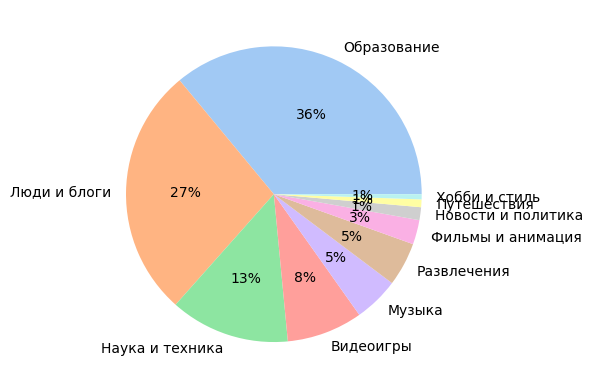

In [296]:
colors = sns.color_palette('pastel')

plt.pie(df_c['LikeCount'], labels = df_c['Category'], colors = colors, autopct='%.0f%%')
plt.show()

In [297]:
result = df_c

## Статистика по кол-ву тэгов и инфографика по тэгам

In [298]:
res = [item for sublist in filtered_dataset['Tags'] if sublist is not None for item in sublist]

Здесь идет предобработка данных.

Мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [299]:
res = [x.lower() for x in res]
res = [re.sub('\d+', '', x) for x in res]
res = [re.sub('[^а-яА-Яa-zA-Z\s]', '', x) for x in res]
res = [x.strip() for x in res]
res = [x for x in res if x.strip() != '']

Результат работы

In [300]:
res

['собеседование в it',
 'собеседование',
 'it',
 'как пройти собеседование в айти',
 'как пройти собеседование',
 'айти',
 'как стать программистом',
 'собес',
 'гайд собеседование в it',
 'полный гайд по собеседованию в it',
 'программирование',
 'python',
 'data science',
 'sql',
 'big data',
 'machine learning',
 'learn python',
 'python для начинающих',
 'data science for beginners',
 'программирование с нуля',
 'питон',
 'питон с нуля',
 'собеседование в it компанию',
 'собеседование на программиста',
 'как пройти собеседование в it',
 'собеседования',
 'гайд',
 'аниме',
 'аниме все серии',
 'фрирен',
 'фрирен провожающая в последний путь',
 'фрирен обзор',
 'фрирен все серии',
 'фрирен пересказ',
 'гиггук фрирен',
 'лучшее аниме',
 'лучшее аниме осени',
 'фрирен аниме',
 'аниме обзор',
 'аниме фэнтези',
 'аниме магия',
 'jpeg',
 'как устроен jpeg',
 'png',
 'alek os',
 'дкп',
 'дискретное косинусное преобразование',
 'квантование',
 'jpg',
 'программирование',
 'основы программир

Здесь мы считаем сколько всего каких тэгов. Например как много таких или иных тэгов

In [301]:
tag_counts = {}
for tag in res:
    tag_counts[tag] = tag_counts.get(tag, 0) + 1
    
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
top_tags = sorted_tags[:50]

Инфографика тэгов

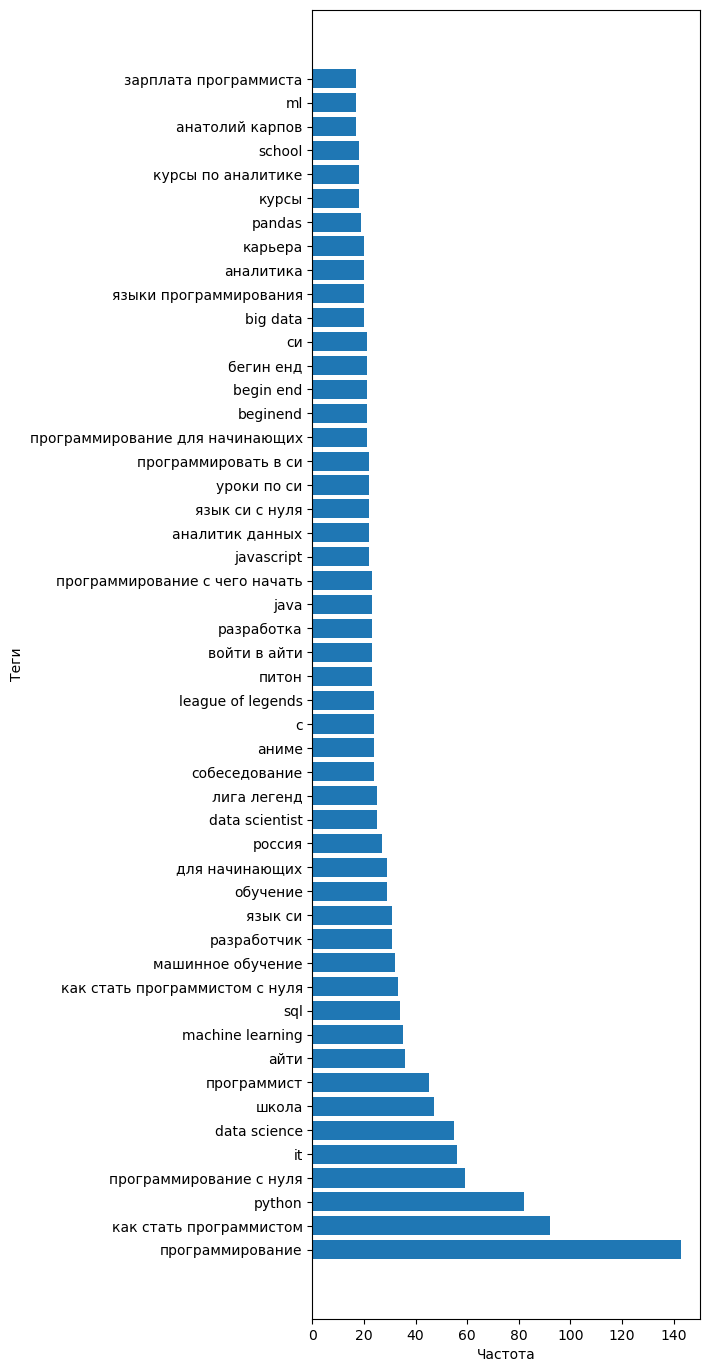

In [302]:
tags, freq = zip(*top_tags)
fig, ax = plt.subplots()

ax.barh(tags, freq)
ax.set_ylabel('Теги')
ax.set_xlabel('Частота')
fig.set_size_inches(5, 17)

plt.show()

In [303]:
result2 = top_tags

## Обучение модели по тэгам

Читаем наш датасет

In [555]:
tag_dataset = pd.read_excel('dataset.xlsx')

Предобработка данных. Снова убираем цифры, делаем нижний регистр, пустые строки убираем и тд.

Убираем кол-во профессий которое меньше 5.

In [556]:
tag_dataset['Tag'] = tag_dataset['Tag'].astype(str)
tag_dataset['Profession'] = tag_dataset['Profession'].astype(str)

tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.lower()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('\d+', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.strip()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[tag_dataset['Tag'] != '']

data_dataset = tag_dataset.groupby(by='Profession').filter(lambda x: len(x['Tag']) >= 10)

Так выглядит наш датасет

In [557]:
data_dataset.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Спортсмен,10
Экономист,10
Автомеханик,11
Художник-аниматор,11
Аниматор,12
Повар,15
Рэпер,18
Разработчик игр,18
Ведущий,18


Мы видим, что некоторых профессий мало, то есть 5. Нам нужно немного сбланасировать классы для того, чтобы модель точнее предсказывала такие прфоессии.

In [558]:
# Определение редких профессий
rare_professions_df = data_dataset.groupby(by='Profession').count().sort_values(by='Tag') < 25
rare_professions_list = rare_professions_df.index[rare_professions_df['Tag']].tolist()

In [559]:
rare_samples = data_dataset[data_dataset['Profession'].isin(rare_professions_list)]
duplicated_samples = rare_samples.sample(n=1000, replace=True)
oversampled_df = pd.concat([data_dataset, duplicated_samples], ignore_index=True)

In [560]:
oversampled_df.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Режиссер,25
Ютубер,29
Музыкант,29
Блогер,31
Актер,34
Аналитик данных,34
Телеведущий,42
Комик,45
Политик,54


In [561]:
# Создание признаков и целевой переменной
X = oversampled_df['Profession']
y = oversampled_df['Tag']

In [562]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [563]:
X_train = np.where(pd.isna(X_train), '', X_train)
X_test = np.where(pd.isna(X_test), '', X_test)

In [564]:
XX_train_tokenized = [text.split() for text in XX_train]
XX_test_tokenized = [text.split() for text in X_test]

In [565]:
model_ft = FastText(
    sentences=XX_train_tokenized, 
    vector_size=100, 
    window=5, 
    min_count=5
)

In [566]:
model_ft

In [567]:
XX_train_embeddings = np.array([np.mean([model_ft.wv.get_vector(word) for word in text], axis=0) for text in XX_train_tokenized])
XX_test_embeddings = np.array([np.mean([model_ft.wv.get_vector(word) for word in text], axis=0) for text in XX_test_tokenized])

In [568]:
# Обучение модели CatBoost
model = CatBoostClassifier(
    iterations=100, 
    depth=10, 
    learning_rate=1
)

model.fit(
    XX_train_embeddings, 
    yy_train,
    
)

0:	learn: 2.1660011	total: 2.92s	remaining: 4m 49s
1:	learn: 1.8904910	total: 5.88s	remaining: 4m 48s
2:	learn: 1.6226186	total: 8.79s	remaining: 4m 44s
3:	learn: 1.4079863	total: 11.6s	remaining: 4m 38s
4:	learn: 1.2141958	total: 14.5s	remaining: 4m 35s
5:	learn: 1.0510547	total: 17.5s	remaining: 4m 34s
6:	learn: 0.9140194	total: 20.4s	remaining: 4m 31s
7:	learn: 0.7945948	total: 23.3s	remaining: 4m 28s
8:	learn: 0.6948311	total: 26.2s	remaining: 4m 25s
9:	learn: 0.6128810	total: 29.1s	remaining: 4m 21s
10:	learn: 0.5425690	total: 31.9s	remaining: 4m 17s
11:	learn: 0.4834608	total: 34.8s	remaining: 4m 15s
12:	learn: 0.4350749	total: 37.7s	remaining: 4m 12s
13:	learn: 0.4000453	total: 40.6s	remaining: 4m 9s
14:	learn: 0.3652619	total: 43.4s	remaining: 4m 6s
15:	learn: 0.3337356	total: 46.3s	remaining: 4m 2s
16:	learn: 0.3080251	total: 49.1s	remaining: 3m 59s
17:	learn: 0.2845892	total: 52s	remaining: 3m 56s
18:	learn: 0.2647815	total: 54.8s	remaining: 3m 53s
19:	learn: 0.2459547	total:

In [570]:
# Классификация текстов
y_pred = model.predict(X_test_bow)

# Оценка качества модели
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [571]:
model.save_model('catboost_model.bin')

Визуализация угаданных данных.

In [572]:
y_pred_df = pd.DataFrame({'Profession': y_pred.flatten()})

In [573]:
profession_counts = y_pred_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']

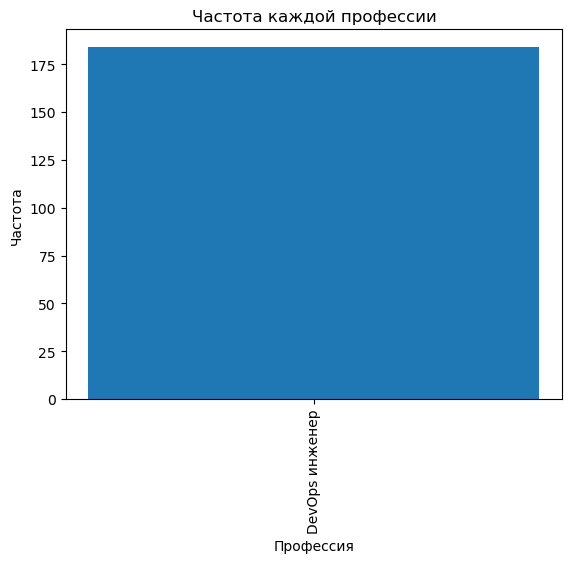

In [574]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Использование реальных данных

In [575]:
# Загрузка модели
model = CatBoostClassifier()
model.load_model('catboost_model.bin')

In [576]:
# Загрузка данных
df = pd.DataFrame(res)
df = df.rename(columns={0: 'Tag'})
df['Tag'] = df['Tag'].astype(str)

In [577]:
text_array = df['Tag'].values.astype(str)
arr_obj = text_array.astype(object)

In [578]:
# Преобразование текстовых данных в числовые с помощью BoW (мешок слов)
XX_real_tokenized = [text.split() for text in arr_obj]

In [579]:
model2_ft = FastText(
    sentences=XX_real_tokenized, 
    vector_size=100, 
    window=5, 
    min_count=5
)

In [580]:
predictions = model.predict(X_train_bow)

In [581]:
result3 = pd.DataFrame(predictions)

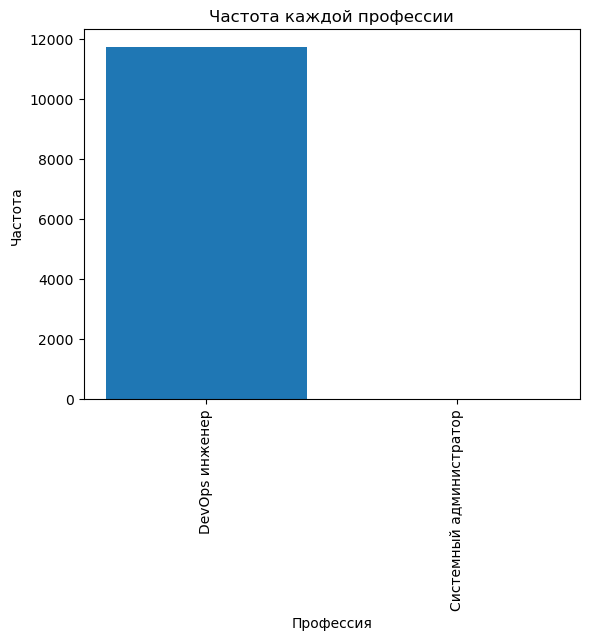

In [582]:
y_pred_df = pd.DataFrame({'Profession': predictions.flatten()})
profession_counts = y_pred_df['Profession'].value_counts().head(20)
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Обучение модели по названием видео

In [583]:
mean_video = filtered_dataset['total_seconds'].mean()
filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1365410757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)


In [584]:
new_model = filtered_dataset[['weight_to_model', 'ChannelTitle', 'Category', 'Title']]

In [585]:
new_model_new = pd.read_excel('new_model_new_xxx.xlsx', sheet_name='model2')

## Предобработка данных

In [630]:
new_model_new['Title'] = new_model_new['Title'].str.lower()
new_model_new['Title'] = new_model_new['Title'].str.replace('\d+', '', regex=True)
new_model_new['Title'] = new_model_new['Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].str.lower()
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].str.replace('\d+', '', regex=True)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

In [631]:
new_model_new

,Title,Profession
0,смарт тв не видит интернет как подключить тел...,Android-разработчик
1,что учить новичку в android java vs kotlin моб...,Android-разработчик
2,как стать androidразработчиком в году,Android-разработчик
3,уроки android studio с нуля разработка андр...,Android-разработчик
4,уроки android studio с нуля интерфеис прогр...,Android-разработчик
5,уроки android studio с нуля написание кода ...,Android-разработчик
6,уроки android studio с нуля всплывающие соо...,Android-разработчик
7,уроки android studio с нуля переход между с...,Android-разработчик
8,чем занимается android разработчик требования ...,Android-разработчик
9,java,Android-разработчик


In [632]:
new_model_new.groupby(by='Profession').count().sort_values(by='Title')

,Title
Profession,
Android-разработчик,49
Backend-разработчик,50
DevOps инженер,50
Frontend-разработчик,50
ML Разработчик,50
Swift-разработчик,50
UI/UX дизайнер,50
Бизнес-аналитик/Системный аналитик/Аналитик данных,50
Разработчик ПО,50


In [633]:
new_model_new['Title'] = new_model_new['Title'].astype(str)
new_model_new['Profession'] = new_model_new['Profession'].astype(str)
new_model_new['weight_to_model'] = new_model_new['weight_to_model'].astype(float)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1427112173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].astype(str)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1427112173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Profession'] = new_model_new['Profession'].astype(str)


KeyError: 'weight_to_model'

In [634]:
new_model_new.dtypes

Title         object
Profession    object
dtype: object

In [637]:
new_model_new = new_model_new[['Title', 'Profession']] ##Норм

In [638]:
new_model_new

,Title,Profession
0,смарт тв не видит интернет как подключить тел...,Android-разработчик
1,что учить новичку в android java vs kotlin моб...,Android-разработчик
2,как стать androidразработчиком в году,Android-разработчик
3,уроки android studio с нуля разработка андр...,Android-разработчик
4,уроки android studio с нуля интерфеис прогр...,Android-разработчик
5,уроки android studio с нуля написание кода ...,Android-разработчик
6,уроки android studio с нуля всплывающие соо...,Android-разработчик
7,уроки android studio с нуля переход между с...,Android-разработчик
8,чем занимается android разработчик требования ...,Android-разработчик
9,java,Android-разработчик


In [639]:
# Создание признаков и целевой переменной
x = new_model_new['Profession']
y = new_model_new['Title']

In [640]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=21)

In [641]:
# Предварительная обработка текста и разделение на токены
x_train_token = [gensim.utils.simple_preprocess(i) for i in x_train]
x_test_token = [gensim.utils.simple_preprocess(i) for i in x_test]

In [642]:
fasttext_model = gensim.models.FastText(
    sentences=x_train_token, 
    vector_size=100, 
    min_count=1, 
    window=5, 
    sg=0, 
    hs=1
)

In [643]:
def sentence_vector(sentence, model):
    if len(sentence)!= 0:
        return np.mean([model.wv[word] for word in sentence], axis=0)
    else:
        return np.zeros(model.vector_size)               # возвращает вектор нулей той же размерности, что и другие векторы

In [644]:
x_train_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_train_token]
x_test_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_test_token]

In [683]:
model2 = CatBoostClassifier(
    iterations=500,
    random_state=11,
    learning_rate=0.1,
)
model2.fit(
    x_train_vec, yy_train,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [684]:
print('Обучена ли модель: ' + str(model2.is_fitted()))

Обучена ли модель: True


In [715]:
# Классификация текстов
y_pred = model2.predict(x_train_vec)

# Оценка качества модели
# accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0


In [690]:
model2.save_model('catboost_model2.bin')

In [691]:
y_pred_df = pd.DataFrame({'Profession': y_pred.flatten()})
profession_counts = y_pred_df['Profession'].value_counts()
# profession_counts = profession_counts[profession_counts.index != 'nan']

In [692]:
profession_counts

Profession
DevOps инженер                                        48
UI/UX дизайнер                                        47
Backend-разработчик                                   47
Разработчик игр                                       47
Бизнес-аналитик/Системный аналитик/Аналитик данных    46
Frontend-разработчик                                  45
Разработчик ПО                                        45
Специалист по информационной безопасности             44
Swift-разработчик                                     44
Android-разработчик                                   43
ML Разработчик                                        42
Системный администратор                               41
Name: count, dtype: int64

Внизу угаданные данные. Мы можем это видеть внизу.

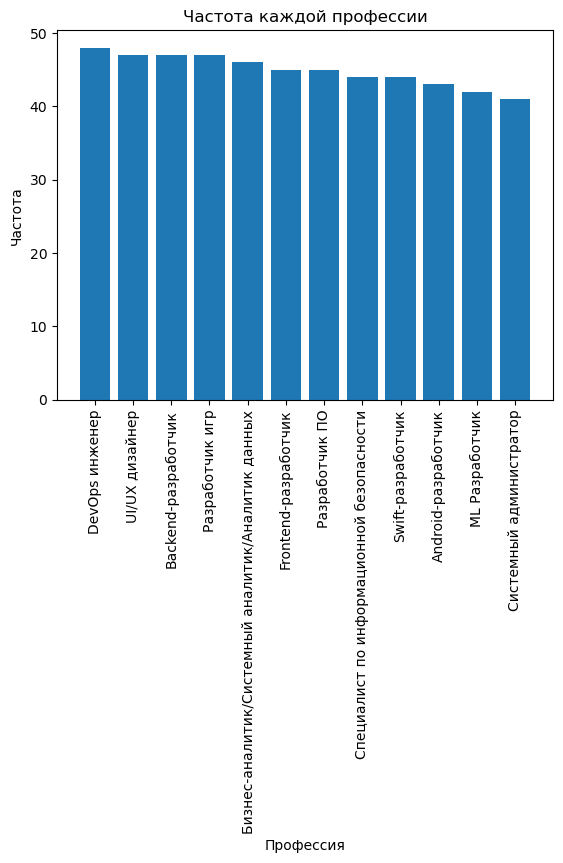

In [693]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Реальные данные

In [716]:
model2 = CatBoostClassifier()
model2.load_model('catboost_model2.bin')

In [717]:
x_real = filtered_dataset['Title']

In [718]:
x_real_token = [gensim.utils.simple_preprocess(i) for i in x_real]

In [719]:
fasttext_model_real = gensim.models.FastText(
    sentences=x_real_token, 
    vector_size=100, 
    min_count=1, 
    window=5, 
    sg=0, 
    hs=1
)

In [720]:
x_real_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_real_token]

In [721]:
predictions = model2.predict(x_real_vec)

In [724]:
y_prediction_df

,Profession
0,Бизнес-аналитик/Системный аналитик/Аналитик да...
1,Frontend-разработчик
2,DevOps инженер
3,DevOps инженер
4,Frontend-разработчик
5,DevOps инженер
6,Специалист по информационной безопасности
7,Frontend-разработчик
8,Системный администратор
9,Специалист по информационной безопасности


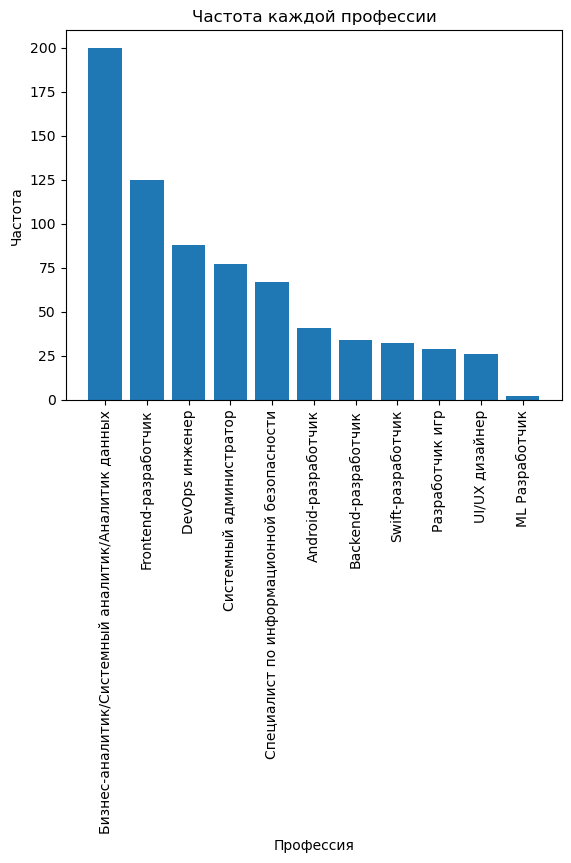

In [722]:
y_prediction_df = pd.DataFrame({'Profession': predictions.flatten()})
profession_counts = y_prediction_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()